In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/RF_signal_classification/"
%cd "/content/gdrive/My Drive/RF_signal_classification/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/RF_signal_classification


In [2]:
# !pip install 'h5py==2.10.0' --force-reinstall

In [3]:
%cd Tech
%ls | grep pickle

/content/gdrive/My Drive/RF_signal_classification/Tech
resnet_result.pickle
ResNet_weights_500_0827_1281.pickle
ResNet_weights_500_0827_1282.pickle
ResNet_weights_500_0827_640.pickle
ResNet_weights_500_0827.pickle
SNR0_img_256.pickle
SNR0_img.pickle
SNR10_img_256.pickle
SNR10_img.pickle
SNR20_img_256.pickle
SNR20_img.pickle
Tech_1500_20.pickle
Tech_1500_9.pickle
Tech_1500.pickle
Tech_2000.pickle
Tech_mod12_test.pickle
Tech_mod16_test.pickle
Tech_mod20_test.pickle
Tech_mod8_test.pickle
Tech_test_500_1_3.pickle
Tech_test_500_FE_unknown.pickle
Tech_test_500.pickle
Tech_test_500_ray.pickle
Tech_test_500_unknown.pickle
Tech_test_mod12.pickle
Tech_test_unknown_.pickle
unknown_FE_500_0902.pickle
Unknown_test_500_0827.pickle
Unknown_test_500_0830_pca100.pickle
Unknown_test_500_0830_pca200.pickle
Unknown_test_500_0830_pca54.pickle


In [4]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

#%resnet
%tensorflow_version 1.x
import tensorflow
import keras
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add

TensorFlow 1.x selected.


Using TensorFlow backend.


In [5]:
TestBench = 'Tech_test_500'
with open('./' + TestBench + '.pickle', 'rb') as f2:
    X, Y = pickle.load(f2)

In [6]:
# 1d conv resnet
def residual_stack(x, f):
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
def build_ResNet(input_shape, classes):
    x_input = Input(input_shape)
    x = x_input
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    # decision making section
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    model = Model(inputs = x_input, outputs = x)
    adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [7]:
labels_test = Y
y_test = labels_test[:, 0]
X_test = X

In [8]:
X_test.shape, y_test.shape

((60000, 2, 1024), (60000,))

In [9]:
BATCH_SIZE = 1024
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = np.array([np.hstack([X_train[x][0].reshape(-1, 1), X_train[x][1].reshape(-1, 1)]) for x in range(X_train.shape[0])])
      self.X_val = np.array([np.hstack([X_val[x][0].reshape(-1, 1), X_val[x][1].reshape(-1, 1)]) for x in range(X_val.shape[0])])
      self.X_test = np.array([np.hstack([X_test[x][0].reshape(-1, 1), X_test[x][1].reshape(-1, 1)]) for x in range(X_test.shape[0])])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath='./' + '%s-weights-{epoch}.hdf5' % self.model_name, verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    self.mod_types = np.unique(y_test)
    #['1_BPSK', '2_QPSK', '3_8PSK', '4_16QAM', '51_FSK', '52_FSK', '53_FSK', '54_FSK', '6_USB', '7_LSB', '8_AM', '9_FM']
    self.mod_to_onehot = preprocessing.LabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    y_hat = self.model.predict(self.X_test, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), np.array(y_hat).argmax(1)] = 1
    y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot)
    y_mod = self.mod_to_onehot.inverse_transform(self.y_test)
    
    with open('./resnet_result.pickle', 'wb') as f2:
        pickle.dump([y_hat, y_hat_onehot, y_hat_mod, self.mod_to_onehot.classes_], f2, pickle.HIGHEST_PROTOCOL)
    print('prediction result saved') 
  def print_summary(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('float')
    for snr in sorted(snrs):
        labels_test = np.array([float(lbl) for lbl in self.labels_test[:,1]])
        idx = np.where(labels_test == snr)
        X_snr = self.X_test[idx]
        y_snr = self.y_test[idx]
        y_hat = self.model.predict(X_snr, self.batch_size)
        y_hat_onehot = np.zeros_like(y_hat)
        y_hat_onehot[np.arange(len(y_hat)), np.array(y_hat).argmax(1)] = 1
        y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot)
        y_mod = self.mod_to_onehot.inverse_transform(y_snr)
        acc = np.mean(y_mod == y_hat_mod)
        snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()), '8-r')
    plt.xlabel("Signal to Noise Ratio", fontsize = 15)
    plt.ylabel("Classification Accuracy", fontsize = 15)
    plt.xticks(list(snr_accs.keys()))
    print('acc labels', list(snr_accs.keys()))
    print('acc results', list(snr_accs.values()))
    plt.title('Accuracy vs. SNR', fontsize = 15)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()

In [10]:
unique = np.unique(y_test)
NUM_CLASSES = len(unique)

In [11]:
idx2mod = {}
for i in range(len(unique)):
    idx2mod[i] = unique[i]

In [12]:
mod2idx = {}
for i in range(len(unique)):
    mod2idx[unique[i]] = i 

In [13]:
mod2idx, idx2mod

({'1_BPSK': 0,
  '2_QPSK': 1,
  '3_8PSK': 2,
  '4_16QAM': 3,
  '51_FSK': 4,
  '52_FSK': 5,
  '53_FSK': 6,
  '54_FSK': 7,
  '6_USB': 8,
  '7_LSB': 9,
  '8_AM': 10,
  '9_FM': 11},
 {0: '1_BPSK',
  1: '2_QPSK',
  2: '3_8PSK',
  3: '4_16QAM',
  4: '51_FSK',
  5: '52_FSK',
  6: '53_FSK',
  7: '54_FSK',
  8: '6_USB',
  9: '7_LSB',
  10: '8_AM',
  11: '9_FM'})

In [14]:
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1024, 40)     120         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1024, 40)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1

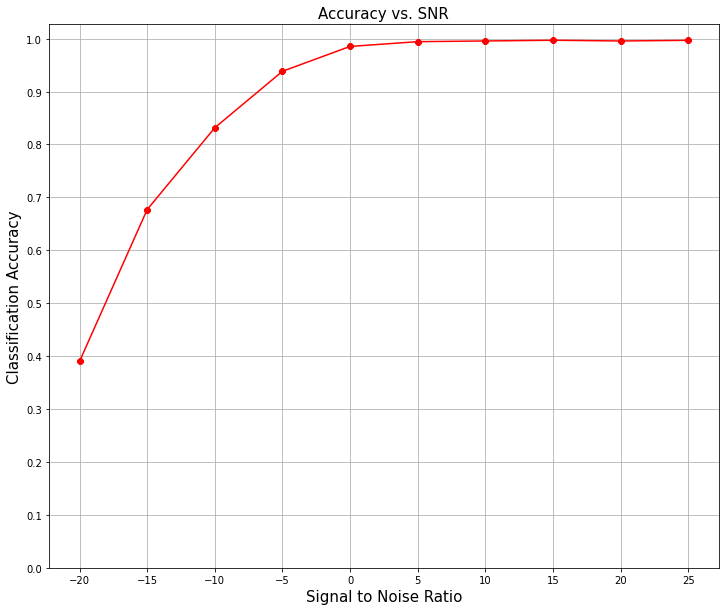

In [15]:
from keras import backend as K
K.clear_session()
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
# resnet_model.load_weights('./res-net_sps8_digital.hdf5')
# resnet_model.load_weights('./res-net_sps8_without_32APSK.hdf5')
# resnet_model.load_weights('../weights/res-net_sps4.hdf5')
# resnet_model.load_weights('../weights/res-net_tau1-weights-98.hdf5')
# resnet_model.load_weights('../weights/res-net_sps20_3_2.hdf5')
# resnet_model.load_weights('../weights/res-net_snr.hdf5')
# resnet_model.load_weights('../weights/res-net_Tech_mod_8_1_3.hdf5')
resnet_model.load_weights('../weights/res-net_Tech_mod_12.hdf5') 
# resnet_model.load_weights('../weights/res-net_sps8_9.hdf5')
# resnet_model.load_weights('../weights/res-net_sps6_7_9.hdf5')
# resnet_model.load_weights('../weights/res-net_sps16_2.hdf5')
# resnet_model.load_weights('../weights/res-net_mix.hdf5')
# resnet_model.load_weights('../weights/res-net_sps20.hdf5')
# resnet_model.load_weights('../weights/res-net_sps20_3_3.hdf5')
resnet_model_evaluater = ModelEvaluater(resnet_model, X_test, y_test, X_test, y_test, X_test, y_test, labels_test, BATCH_SIZE, 'resnet_model',  channels_first=False)
resnet_model_evaluater.print_summary()

In [16]:
with open('./resnet_result.pickle', 'rb') as f1:
    y_hat, y_hat_onehot, y_hat_mod, y_mod = pickle.load(f1)
y_hat, y_hat_onehot, y_hat_mod

(array([[3.88633981e-02, 1.03866450e-01, 1.35079503e-01, ...,
         4.66277227e-02, 6.24803118e-02, 5.03303766e-01],
        [1.68328926e-01, 6.74155429e-02, 7.97328949e-02, ...,
         5.14799893e-01, 1.41964410e-04, 2.58867219e-02],
        [7.46316314e-02, 1.10642083e-01, 9.65097845e-02, ...,
         2.81111568e-01, 5.94240337e-05, 8.48982856e-02],
        ...,
        [1.18500669e-11, 1.95837413e-09, 6.28826765e-12, ...,
         1.16520615e-09, 2.68760491e-13, 1.00000000e+00],
        [1.10350748e-11, 1.67838343e-09, 5.52526427e-12, ...,
         1.25039368e-09, 2.74191504e-13, 1.00000000e+00],
        [1.12901945e-11, 1.82300108e-09, 5.66839891e-12, ...,
         1.17676202e-09, 3.07733656e-13, 1.00000000e+00]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dt

In [17]:
#10 frames voting strategy

sublabels = []
slength = 10
for i in range(0, y_test.shape[0], slength):
    if labels_test[i].tolist() == labels_test[i+slength - 1].tolist():
        
        sublabels.append(labels_test[i])
        # print(y_hat_mod[i:i+slength])
    # print(np.unique(labels_test[i:i + (slength - 1)][:,0]))
    if np.unique(labels_test[i:i + (slength)]).shape[0] > 2:
        print(i, labels_test[i:i + (slength)])

In [18]:
sublabels = []
for i in range(0, y_test.shape[0], slength):
    if labels_test[i].tolist() == labels_test[i+slength - 1].tolist():
        
        sublabels.append(labels_test[i])
        # np.unique(labels_test[i:i + 9]))
    else:
        print('ERROR')
y_pred_sub = []
for i in range(0, y_test.shape[0], slength):
    y_hat_10frame = np.sum(y_hat[i:i+slength], axis = 0)
    y_pred_sub.append(idx2mod[np.argmax(y_hat_10frame)])
y_pred_sub = np.array(y_pred_sub)
sublabels = np.array(sublabels)

acc labels [-20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
acc results [0.7166666666666667, 0.8033333333333333, 0.9066666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


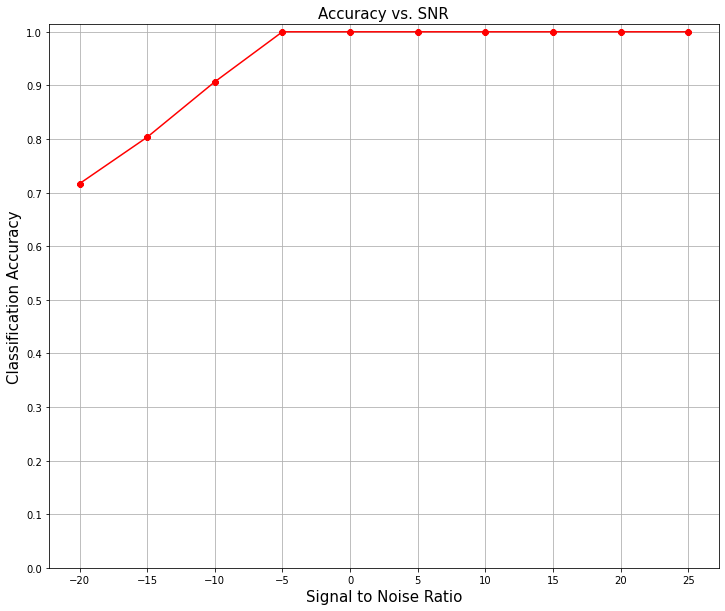

In [19]:
snr_accs = {}
snrs = [-20, -15, -10, -5, 0, 5, 10, 15, 20, 25]
SNR = np.array([float(lbl) for lbl in sublabels[:,1]])
IDX = {}
for snr in sorted(snrs):
    idx = np.where(SNR == snr)
    IDX[snr] = idx
    y_hat_mod = y_pred_sub[idx]
    y_mod = sublabels[:,0][idx]
    acc = np.mean(y_mod == y_hat_mod)
    snr_accs[snr] = acc
# plot the accuracy against the snr
plt.plot(list(snr_accs.keys()),list(snr_accs.values()), '8-r')
plt.xlabel("Signal to Noise Ratio", fontsize = 15)
plt.ylabel("Classification Accuracy", fontsize = 15)
plt.xticks(list(snr_accs.keys()))
print('acc labels', list(snr_accs.keys()))
print('acc results', list(snr_accs.values()))
plt.title('Accuracy vs. SNR', fontsize = 15)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

def generate_confusion_matrix(y_mod, y_hat_mod):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    # mod_to_idx = {'16APSK': 0, '16QAM': 1, '32APSK': 2, '4QAM': 3, '64QAM': 4, '8PSK': 5, 'BPSK': 6, 'CPFSK': 7, 'QPSK': 8}
    # mod_to_idx = {'-10': 2, '-14': 1, '-18': 0, '-2': 4, '-6': 3, '10': 7, '14': 8, '18': 9, '2': 5, '6': 6}
    acc = np.mean(y_mod == y_hat_mod)
    print('accuracy', acc)
    # fill in the confusion matrix
    confusion_mat = np.zeros([len(idx2mod.keys()), len(idx2mod.keys())])
    # confusion_mat = np.zeros([11, 11])
    for ind in range(y_mod.shape[0]):
        # print(ind)
        true_idx = mod2idx[y_mod[ind]]
        pred_idx = mod2idx[y_hat_mod[ind]]
        # print(ind, true_idx, pred_idx)     
        confusion_mat[true_idx, pred_idx,] += 1

    # normalize the matrix column wise
    for i in range(len(idx2mod.keys())):
        if np.sum(confusion_mat[i,:]) > 0:
            confusion_mat[i,:] /= np.sum(confusion_mat[i,:])
    labels_ = mod2idx.keys()
    plot_confusion_matrix(confusion_mat, title='Confusion matrix, %s segments'%str(slength) + ', classification acc = %s'%acc, cmap=plt.cm.Blues, labels = labels_)
    return confusion_mat, acc


accuracy 0.9426666666666667


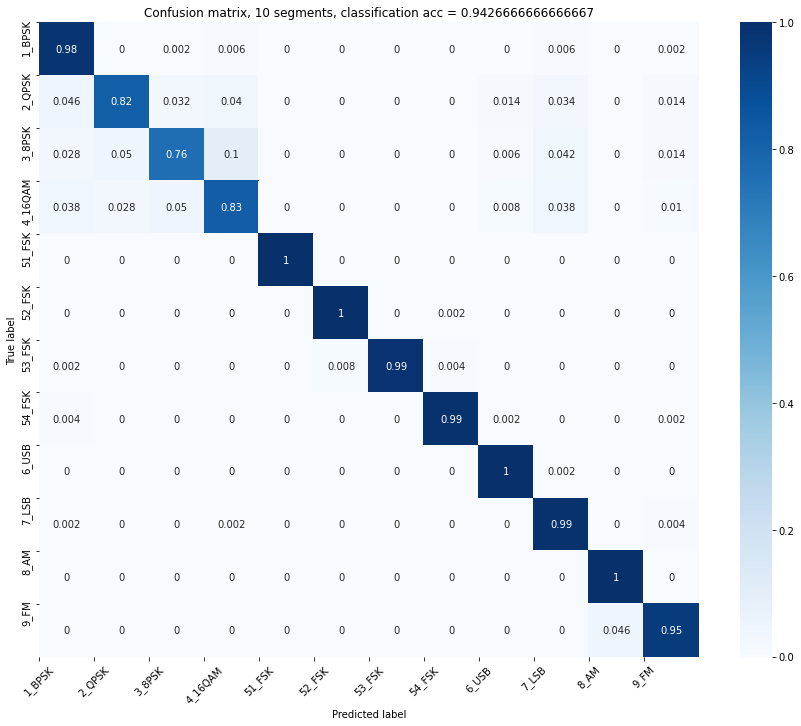

In [21]:
y_true_mod = sublabels[:,0]
y_pred_mod = y_pred_sub
y_hat_mod, y_mod 
cm, acc = generate_confusion_matrix(y_true_mod, y_pred_mod)
